In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:0')

torch.manual_seed(121)

In [ ]:
class PIRBN(nn.Module):

    def __init__(self, centers, b_init=1.0, dtype=torch.float64):
        super().__init__()
        self.dtype = dtype
        
        self.register_buffer('centers', centers.to(dtype))
        self.N = centers.shape[0]
        
        self.b = nn.Parameter(b_init * torch.ones(1, self.N, dtype=dtype))  # shape parameters
        self.a = nn.Parameter(torch.randn(self.N, 1, dtype=dtype))          # output weights

    def forward(self, x):

        x_exp = x.unsqueeze(1)           
        c_exp = self.centers.unsqueeze(0) 
        
        dist_sq = torch.sum((x_exp - c_exp)**2, dim=2)
        
        rbf = torch.exp(-self.b**2 * dist_sq) 
        
        u = torch.matmul(rbf, self.a)
        return u

    def u_x(self, x):

        x.requires_grad_(True)
        u = self.forward(x)
        grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                     create_graph=True)[0]
        return grad_u[:, 0:1]  # ∂u/∂x

    def u_xx(self, x):

        x.requires_grad_(True)
        u_x = self.u_x(x)
        grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                       create_graph=True)[0]
        return grad_u_x[:, 0:1]  

    def u_t(self, x):

        x.requires_grad_(True)
        u = self.forward(x)
        grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                     create_graph=True)[0]
        return grad_u[:, 1:2]  


In [ ]:

e = 0.15

def analytical(x,t):
    et = 2*t-1
    ex = torch.exp(1/(et**2 + e))

    return (1-x**2)*ex


def right_side(x,t):
    et = 2*t-1
    ex = torch.exp(1/(et**2 + e))

    return 2*ex*(1 + 2*et*(x**2-1)/(et**2+e)**2)


In [ ]:
Nx = 64   
Nt = 64   
x_centers = torch.linspace(-1.2, 1.2, Nx, dtype=torch.float64)  
t_centers = torch.linspace(-0.2, 1.2, Nt, dtype=torch.float64) 
X_centers, T_centers = torch.meshgrid(x_centers, t_centers, indexing='ij')
centers = torch.stack([X_centers.flatten(), T_centers.flatten()], dim=1)  

N_colloc = 10000
x_colloc = 2 * torch.rand(N_colloc, 1, dtype=torch.float64) - 1.0  
t_colloc = torch.rand(N_colloc, 1, dtype=torch.float64)             
xt_colloc = torch.cat([x_colloc, t_colloc], dim=1).to(device)

N_bc = 1000
x_left  = torch.full((N_bc, 1), -1.0, dtype=torch.float64)
x_right = torch.full((N_bc, 1),  1.0, dtype=torch.float64)
x_bc = torch.cat([x_left, x_right], dim=0)
t_bc = torch.rand(2*N_bc, 1, dtype=torch.float64)
xt_bc = torch.cat([x_bc, t_bc], dim=1).to(device)

N_ic = 1000
x_ic = 2 * torch.rand(N_ic, 1, dtype=torch.float64) - 1.0
t_ic = torch.zeros_like(x_ic)
xt_ic = torch.cat([x_ic, t_ic], dim=1).to(device)


In [ ]:
model = PIRBN(centers, b_init=5.0, dtype=torch.float64).to(device)

xt_colloc = xt_colloc.to(device)
xt_bc = xt_bc.to(device)
xt_ic = xt_ic.to(device)

print(f"PIRBN has {sum(p.numel() for p in model.parameters()):,} parameters")


PIRBN has 8,192 parameters


In [ ]:
# Training

optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-2)

optimizer2 = torch.optim.LBFGS(model.parameters(), 
                             lr=1.0,
                             max_iter=10**6,
                             max_eval=10**5,
                             tolerance_grad=1e-06,
                             tolerance_change=1e-06,
                             history_size=20,
                             line_search_fn=None)


epochs = 10**3
print_interval = 500

x_validate = 2 * torch.rand(1000, 1, dtype=torch.float64, device=device) - 1.0
t_validate = torch.rand(1000, 1, dtype=torch.float64, device=device)
xt_validate = torch.cat([x_validate, t_validate], dim=1)



def loss_print(pde_loss, bc_loss, ic_loss, model, epoch):
    with torch.no_grad():           
        # Predictions and exact values
        u_pred_validate = model(xt_validate)
        u_exact_validate = analytical(x_validate, t_validate)
        # Relative L2 error
        l2_error = torch.sqrt(torch.mean((u_pred_validate - u_exact_validate)**2)) / \
                    torch.sqrt(torch.mean(u_exact_validate**2))
    
    print(f"\n Epoch {epoch:6d} | "
            f"PDE: {pde_loss.item():.2e} | BC: {bc_loss.item():.2e} | IC: {ic_loss.item():.2e} | "
            f"L2_rel: {l2_error.item():.2e}")
     



def loss(model):
    xt_colloc.requires_grad_(True)
    u_pred = model(xt_colloc)
    u_t_pred = model.u_t(xt_colloc)
    u_xx_pred = model.u_xx(xt_colloc)
    f_pred = right_side(xt_colloc[:, 0:1], xt_colloc[:, 1:2]).to(device)
    pde_loss = torch.mean((u_t_pred - u_xx_pred - f_pred)**2)
    
    u_bc = model(xt_bc)
    bc_loss = torch.mean(u_bc**2)
    
    u_ic = model(xt_ic)
    u_ic_exact = analytical(xt_ic[:, 0:1], xt_ic[:, 1:2]).to(device)
    ic_loss = torch.mean((u_ic - u_ic_exact)**2)
    
    loss = pde_loss + bc_loss + ic_loss

    return loss, pde_loss, ic_loss, bc_loss



def closure():
        global itr
        optimizer2.zero_grad()
        total_loss, pde_loss, ic_loss, bc_loss = loss(model)


        total_loss.backward()

        if itr % 1000 == 0:
            loss_print(pde_loss, bc_loss, ic_loss, model, itr)
        
        itr += 1

        return total_loss
       


In [ ]:
global itr
itr = 0



for epoch in tqdm(range(1, epochs + 1)):
    optimizer1.zero_grad()
    total_loss, pde_loss, ic_loss, bc_loss = loss(model)

    total_loss.backward()
    optimizer1.step()
    
    if epoch % print_interval == 0: 
         loss_print(pde_loss, bc_loss, ic_loss, model, epoch)


print("\n\n ========== Starting L-BFGS optimization  ===========")

loss = optimizer2.step(closure)

  0%|          | 0/1000 [00:00<?, ?it/s]/envs/common/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 504/1000 [01:44<01:27,  5.67it/s]


 Epoch    500 | PDE: 2.22e+06 | BC: 9.38e+03 | IC: 4.21e+02 | L2_rel: 4.80e-01


100%|██████████| 1000/1000 [03:28<00:00,  4.81it/s]


 Epoch   1000 | PDE: 1.44e+06 | BC: 4.87e+03 | IC: 6.46e+01 | L2_rel: 3.26e-01


 ========== Starting L-BFGS optimization  ===========



 Epoch      0 | PDE: 1.43e+06 | BC: 4.86e+03 | IC: 6.47e+01 | L2_rel: 3.26e-01

 Epoch   1000 | PDE: 1.65e+03 | BC: 5.99e+02 | IC: 5.27e+00 | L2_rel: 6.00e-02

 Epoch   2000 | PDE: 9.90e+02 | BC: 1.43e+02 | IC: 9.87e-01 | L2_rel: 2.66e-02

 Epoch   3000 | PDE: 8.18e+02 | BC: 7.16e+01 | IC: 3.09e-01 | L2_rel: 1.79e-02

 Epoch   4000 | PDE: 7.06e+02 | BC: 3.71e+01 | IC: 3.58e-01 | L2_rel: 1.27e-02

 Epoch   5000 | PDE: 6.15e+02 | BC: 2.56e+01 | IC: 4.98e-01 | L2_rel: 1.09e-02

 Epoch   6000 | PDE: 5.46e+02 | BC: 2.10e+01 | IC: 8.23e-02 | L2_rel: 9.54e-03

 Epoch   7000 | PDE: 4.93e+02 | BC: 1.92e+01 | IC: 5.79e-02 | L2_rel: 9.29e-03

 Epoch   8000 | PDE: 4.59e+02 | BC: 1.59e+01 | IC: 9.95e-02 | L2_rel: 8.34e-03

 Epoch   9000 | PDE: 4.29e+02 | BC: 1.41e+01 | IC: 8.66e-02 | L2_rel: 7.83e-03

 Epoch  10000 | PDE: 4.06e+02 | BC: 1.27e+01 | IC: 1.07e-01 | L2_rel: 7.42e-03

 Epoch  11000 | PDE: 3.90e+02 | BC: 1.24e+01 | IC: 3.91e-02 | L2_rel: 7.46e-03

 Epoch  12000 | PDE: 3.72e+02 | BC: 1.2

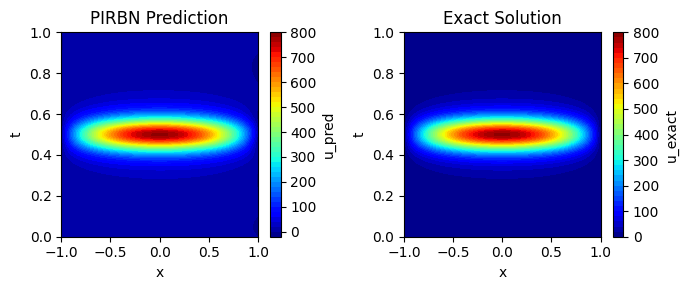

Relative L2 error: 4.38e-03


In [8]:
# Evaluate on a fine grid
N_eval = 200
x_eval = torch.linspace(-1, 1, N_eval, dtype=torch.float64).to(device)
t_eval = torch.linspace(0, 1, N_eval, dtype=torch.float64).to(device)
X_eval, T_eval = torch.meshgrid(x_eval, t_eval, indexing='ij')
XT_eval = torch.stack([X_eval.flatten(), T_eval.flatten()], dim=1)

with torch.no_grad():
    u_pred = model(XT_eval).view(N_eval, N_eval).cpu().numpy()
    u_exact = analytical(X_eval, T_eval).cpu().numpy()

# Plot
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.contourf(X_eval.cpu(), T_eval.cpu(), u_pred, levels=50, cmap='jet')
plt.colorbar(label='u_pred')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PIRBN Prediction')

plt.subplot(1, 2, 2)
plt.contourf(X_eval.cpu(), T_eval.cpu(), u_exact, levels=50, cmap='jet')
plt.colorbar(label='u_exact')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')

plt.tight_layout()
plt.show()

# Compute L2 error
l2_error = np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
print(f"Relative L2 error: {l2_error:.2e}")
